Code sample taken from work done as part of the ESA HyperClass grant at the University of Strathclyde during my time as an RA in the Advanced Space Concepts Lab.

The purpose of this code is to predict from hyperspectral sensor readings of unknown space objects, the fraction of the total recieved light that is due to each of the present materials. This information was then further processed to determine the presence of large components such as solar panels, antennas etc to assist in classifying unknown satellites. Only the material reconstruction is shown in this notebook.

This problem is solved by using an ANN with outputs constrained by a custom loss function such that their sum should be equal to 1. The training data used here was obtained by generating a large number of random linear combinations of N material spectra, constrained such that their sum equals 1. Validation data used to determine the performance of the model was simulated hyperspectral sensor data obtained from the output of a separate model that I built in MATLAB as part of the project.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from packages.preprocessing import movmean
from packages.myFunctions import *
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from numpy import inf
import matplotlib.pyplot as plt
import time
from keras.utils import np_utils
import pandas as pd
import copy
from scipy.io import loadmat
import mat73


Load data

In [2]:
filename = '../training_data/material_fractions_dataset1.mat'

X = mat73.loadmat(filename)['X']
y = mat73.loadmat(filename)['y']
materials = mat73.loadmat(filename)['materials']
bands = mat73.loadmat(filename)['bands']

y = pd.DataFrame(y, columns=materials)

y = y.sort_index(axis=1)
materials = list(y.head())

y = y.to_numpy()

In order to remove the variable effect of distance on the light intensity recieved, the raw data (in photon counts) must be normalised appropriately. Here we use colour indexing, which expresses the recieved spectrum not in absolute terms, but relative to some arbitrary wavelength band. This code block selects which transformation to apply (various forms of colour indexing were tested and compared) to both the training data and the validation data.

In [3]:
intensity_mode = 'colour_index'

if intensity_mode == 'colour_index':
    X = -2.5*np.log10(row_divide(X,X[:,50]))
    
elif intensity_mode == 'broadband_CI':
    filters = np.array([[475.144, 509.856],
           [510.1055, 543.2545],
           [565.4065, 592.5735],
           [592.8115, 621.7885],
           [640.74, 690.44],
           [698.009, 715.071],
           [745.0345, 764.2255],
           [789.3065, 815.3335],
           [839.16, 857.7],
           [959.94, 987.76]])
    X = aggregate_filters(X, 0, bands, filters)
    X = -2.5*np.log10(row_divide(X,X[:,-1]))

elif intensity_mode == 'cordelli':
    filters = np.array([[455, 490],
           [490, 565],
           [575, 710]])
    X = aggregate_filters(X, 0, bands, filters)
    X = -2.5*np.log10(row_divide(X,X[:,-1]))
    
                
# Sicne we validate on a different type of data, no train/test split is used.
X_train, y_train = X, y

The validation set is now loaded from one of the simulated satellite classes, iridiumNEXT, using custom functions to unpack the data and remove the effects of atmospheric attenuation

In [4]:
X_val, y_val, info = build_dataset_discrete_time(num_samples=6020,
                                                 classes=['iridiumNEXT'],
                                                 dataFolder='data8/atmo_complex_mats',
                                                 shuffle_samples=False,
                                                 get_separation_vector=True,
                                                 get_airmass=True,
                                                 get_phase_angle=True)
    
X_val = remove_atmospheric_attenuation(X_val[:,:info['idx_sensor_data']], info['bands'], 5, X_val[:, info['idx_airmass']])
    

materials_val = list(y_val.head())
print(f'Validation set materials = {materials_val}')


# Apply spectral transformation

if intensity_mode == 'colour_index':
    X_val = -2.5*np.log10(row_divide(X_val,X_val[:,50]))

elif intensity_mode == 'broadband_CI':
    filters = np.array([[475.144, 509.856],
                        [510.1055, 543.2545],
                        [565.4065, 592.5735],
                        [592.8115, 621.7885],
                        [640.74, 690.44],
                        [698.009, 715.071],
                        [745.0345, 764.2255],
                        [789.3065, 815.3335],
                        [839.16, 857.7],
                        [959.94, 987.76]])
    X_val = aggregate_filters(X_val, 0, bands, filters)
    X_val = -2.5*np.log10(row_divide(X_val,X_val[:,-1]))
    
elif intensity_mode == 'cordelli':
    filters = np.array([[455, 490],
           [490, 565],
           [575, 710]])
    X_val = aggregate_filters(X_val, 0, bands, filters)
    X_val = -2.5*np.log10(row_divide(X_val,X_val[:,-1]))
    

# Adding zero columns to the validation set for those materials which are in the library
# (train set) but not in the validation set

for m in materials:
    if m not in materials_val:
        y_val[m] = 0
            
y_val = y_val.sort_index(axis=1)
print(y_val.head())

y_val = y_val.to_numpy()

Loading data from folder /data8/atmo_complex_mats
../training_data/data8/iridiumNEXT/atmo_complex_mats/batch1.mat
Validation set materials = ['gaas_panel', 'aluminiumBlanket45', 'goldThermalBlanket45', 'copper_scaled', 'USGSWhitePaint']
   USGSBlackPaint  USGSGreenPaint  USGSRedPaint  USGSWhitePaint  \
0               0               0             0        0.116279   
1               0               0             0        0.116294   
2               0               0             0        0.116310   
3               0               0             0        0.116326   
4               0               0             0        0.116343   

   aluminiumBlanket45  copper_scaled  gaas_panel  goldThermalBlanket45  \
0            0.335552       0.017592    0.089015              0.441563   
1            0.335375       0.017583    0.088860              0.441888   
2            0.335201       0.017574    0.088705              0.442210   
3            0.335028       0.017565    0.088550              0.

Preview the first 100 train and validation spectra to visually check the inputs are correctly scaled.

Text(0, 0.5, 'Intensity')

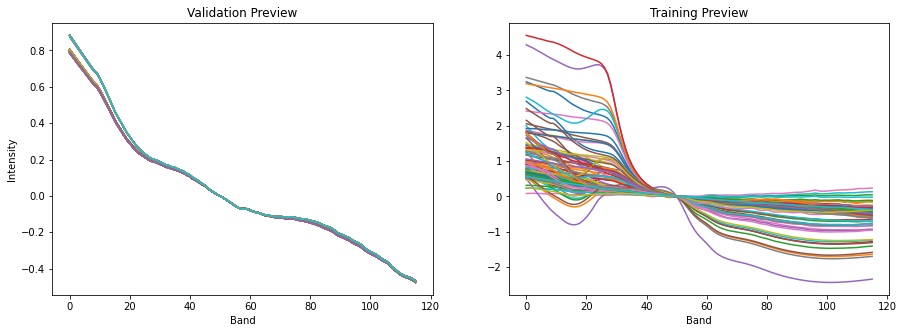

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i in range(0,100):
    ax[0].plot(X_val[i,:])
    ax[1].plot(X_train[i,:])

ax[0].set_title('Validation Preview')
ax[0].set_xlabel('Band')
ax[0].set_ylabel('Intensity')

ax[1].set_title('Training Preview')
ax[1].set_xlabel('Band')
ax[0].set_ylabel('Intensity')

Now the ANN model is initialised and trained using Keras. The below cell shows the final model that was chosen after hyperparameter tuning - it was found that a combination of ReLU and sigmoid in the hidden layers resulted in the best performance as measured by validation loss. The number of units in the hidden layers were also tuned.

Since we are essentially matching to a library of m materials, the number of output units must be m. The softmax activation function was chosen for the output since, similar to a probability distribution, the sum of the outputs must equal 1, and we cannot have a negative fraction of some material. Since this is not a classification problem, however, MSE loss was used to determine the quality of preditcions.

Since the train set contains 900,000 samples and this was being trained on a GPU with ample memory, a large minibatch size of 150,000 was used.

In [14]:
in_dim = np.size(X_train[0, :])
K.clear_session()

def build_model():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=in_dim, activation='relu'))
    model.add(Dense(20, activation='sigmoid'))
    model.add(Dense(np.shape(y)[1], activation='softmax'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


num_epochs = 100
model = KerasRegressor(build_fn=build_model, epochs=num_epochs, batch_size=150000, verbose=1, validation_data=(X_val, y_val))

print('Training...')
start_time = time.time()
history = model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f'Training time: {train_time} seconds')

C:\Users\lewis\AppData\Local\Temp\ipykernel_29472\780389282.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, epochs=num_epochs, batch_size=150000, verbose=1, validation_data=(X_val, y_val))


Training...
Epoch 1/100
60/60 [==============================] - 3s 31ms/step - loss: 0.0365 - val_loss: 0.0187
Epoch 2/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0289 - val_loss: 0.0135
Epoch 3/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0217 - val_loss: 0.0084
Epoch 4/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0158 - val_loss: 0.0069
Epoch 5/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0128 - val_loss: 0.0064
Epoch 6/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0115 - val_loss: 0.0062
Epoch 7/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0107 - val_loss: 0.0058
Epoch 8/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0102 - val_loss: 0.0055
Epoch 9/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0099 - val_loss: 0.0052
Epoch 10/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0096 - val_

60/60 [==============================] - 2s 29ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 83/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 84/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 85/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 86/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 87/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 88/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 89/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0055 - val_loss: 0.0031
Epoch 90/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 91/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0057 - val_loss: 0.0023
Epo

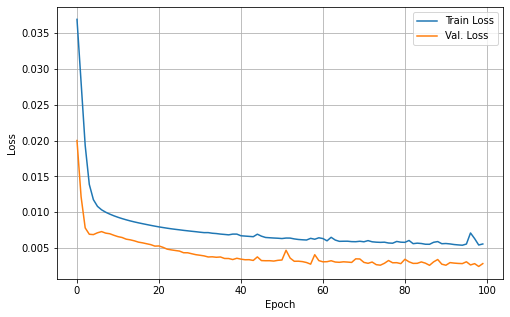

In [7]:
df = pd.DataFrame(history.history)
ax = df['loss'].plot(figsize=(8, 5), label='Train Loss')
df['val_loss'].plot(figsize=(8, 5), label='Val. Loss')

ax.legend()
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.grid(True)
plt.show()

The validation loss converges to a lower value than the training loss, however since the two sets were drawn from different distributions this is not unsurprising - the training set is likely to be more challenging to fit to since it spans the full 9-dimensional space of combinations whereas real objects likely do not span the full space uniformly.

We now plot a random sample of the validation set to compare truth and predictions. Since validation samples were not shuffled, consecutive samples here represent consecutive time points. We see a close matach between the truth and prediction curves with the exception of black paint. Upon further investigation this appears to be inherent to this material and the difficulty in prediction is due to the fact that the reflectivity spectrum of black paint is many times lower than that of all other materials in the library, while also being fairly flat in the wavelength range studied.

1/1 [==============================] - 0s 15ms/step


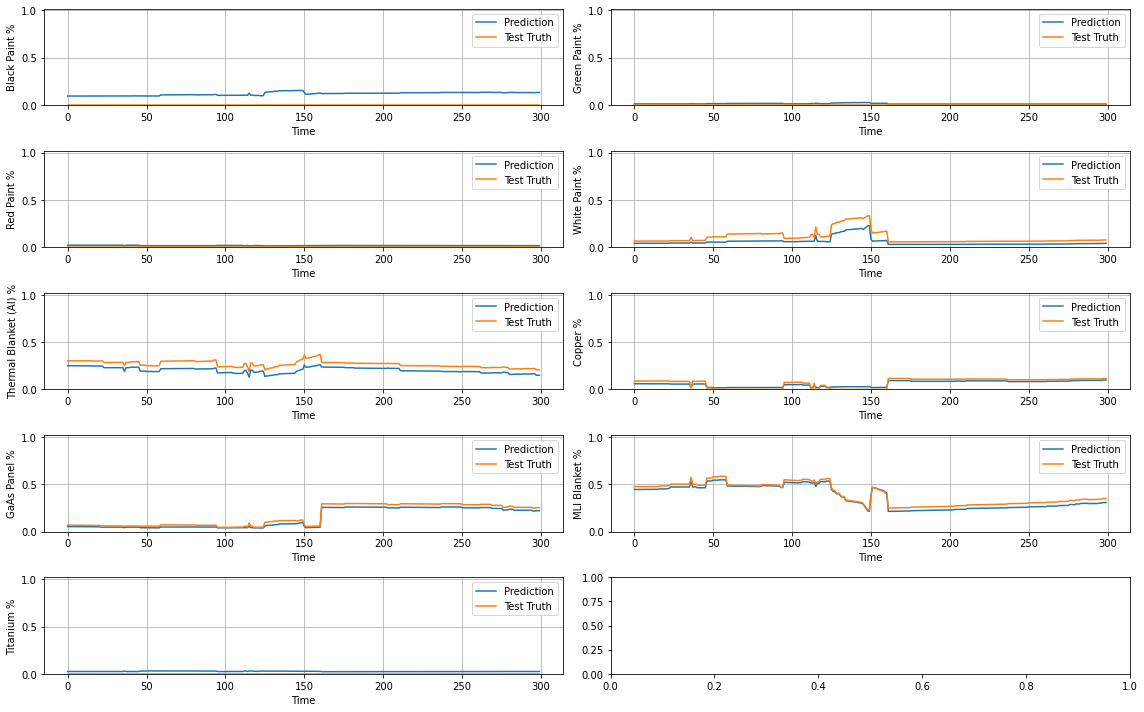

In [12]:
material_labels = ['Black Paint', 'Green Paint', 'Red Paint', 'White Paint', 'Thermal Blanket (Al)', 'Copper', 'GaAs Panel', 'MLI Blanket', 'Titanium', ]

y_pred = model.predict(X_val)

fig, ax = plt.subplots(nrows=int(np.ceil(np.shape(y)[1]/2)), ncols=2)
fig.set_figheight(10)
fig.set_figwidth(16)

n_start = int(np.random.rand()*np.shape(y_val)[0])
n_points = 300

ax = ax.flatten()

for i in range(0, np.shape(y)[1]):
    ax[i].plot(y_pred[n_start:n_start+n_points, i], label=f'Prediction')
    ax[i].plot(y_val[n_start:n_start+n_points, i], label='Test Truth')
    ax[i].set_ylim(0,1.02)
    ax[i].grid()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel(f'{material_labels[i]} %')
    ax[i].legend()

fig.tight_layout()

In [13]:
# Save model
model.model.save('cc_model')

INFO:tensorflow:Assets written to: cc_model\assets
